In [ ]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn 

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from typing import Tuple

from tqdm import tqdm
from box import Box

from copy import deepcopy

In [ ]:
def setSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

# 1. Dataset Preprocessing
    
* Implicit Feedback

In [ ]:
class DataInfo():
    def __init__(self, file_path: str, num_valid: int) -> None:
        self.df = pd.read_csv(file_path)
        self.user_encoder, self.movie_encoder = self._encode()

        self.users = self.df['user'].unique()
        self.num_users = len(self.users)
        self.min_feedback = 5 # for resolving cold-start problem
        self.movies = self.df['item'].unique()
        self.num_movies = len(self.movies)
        self.train_movies = self._moreThanFeedback()
        self.num_train_movies = len(self.train_movies)

        self.df_pos_user_sequence, self.user_negative_samples = self._makeSequenceAndNeg()

        self.num_valid = num_valid
        self.df_pos_train, self.df_pos_test = self._trainTestSplit()
    
    def _trainTestSplit(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        # https://github.com/scikit-learn/scikit-learn/pull/16236
        # GroupTimeSeriesSplit이 PR 중이라고 해서 직접 구현을 해야한다.

        print('train and test split...')
        df_train = {
            'user_id': list(),
            'movie_id': list(),
        }

        df_test = {
            'user_id': list(),
            'movie_id': list(),
        }

        for user in tqdm(self.users):
            df_user = self.df_pos_user_sequence[self.df_pos_user_sequence['user_id']==user]
            list_user_movies = df_user['movie_id'].tolist()

            num_user = df_user.shape[0]
            num_train_user = num_user - self.num_valid
            num_test_user = self.num_valid

            list_user_train_movies = list_user_movies[:num_train_user]
            list_user_test_movies = list_user_movies[num_train_user:]

            df_train['user_id'].extend([user]*num_train_user)
            df_train['movie_id'].extend(list_user_train_movies)

            df_test['user_id'].extend([user]*num_test_user)
            df_test['movie_id'].extend(list_user_test_movies)
            
        df_train = pd.DataFrame(df_train)
        df_train['label'] = 1

        df_test = pd.DataFrame(df_test)
        df_test['label'] = 1

        print('done!')
            
        return df_train, df_test        


    def _moreThanFeedback(self):
        print('pick trainable feedback...')
        
        movie_ids_for_training = list()
        for movie_id in tqdm(self.df['item'].unique()):
            if self.df[self.df['item'] == movie_id].shape[0] >= self.min_feedback:
                movie_ids_for_training.append(movie_id)
        
        print('doen!')
        
        return np.unique(movie_ids_for_training)


    def _makeSequenceAndNeg(self):

        print('sorted by sequence and make negative smaples...')
        pos_user_sequence = {
            'user_id': list(),
            'movie_id': list(),
        }

        user_negative_samples = dict()


        for user in tqdm(self.users):
            user_sequence_movies = self.df[self.df['user']==user].sort_values(by='time', axis=0)['item'].tolist()
            # 최소 조건을 만족하지 못한 것 포함, feedback있는 영화를 제외시킨다. 
            user_negative_movies = np.setdiff1d(self.movies, np.unique(user_sequence_movies))
            user_negative_samples[user] = user_negative_movies

            for movie in user_sequence_movies:
                # 최소 feedback 조건을 만족시키지 못한 것은 추가하지 않는다.
                if movie not in self.train_movies: continue
                pos_user_sequence['user_id'].append(user)
                pos_user_sequence['movie_id'].append(movie)


        df_pos_user_sequence = pd.DataFrame(pos_user_sequence)
        df_pos_user_sequence['label'] = 1

        print('doen!')

        return df_pos_user_sequence, user_negative_samples


    def _encode(self) -> Tuple[pd.DataFrame, LabelEncoder, LabelEncoder]:
        print('encoding...')

        userId_label_encoder = LabelEncoder()
        movieId_label_encoder = LabelEncoder()

        self.df['user'] = userId_label_encoder.fit_transform(self.df['user'].values)
        self.df['item'] = movieId_label_encoder.fit_transform(self.df['item'].values)

        print('done!')

        # encoder.inverse_transform() 으로 decode
        return userId_label_encoder, movieId_label_encoder

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
            
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        user = self.df.iloc[idx]['user_id']
        item = self.df.iloc[idx]['movie_id']
        label = self.df.iloc[idx]['label']
        
        return torch.tensor(user).to(torch.int64), torch.tensor(item).to(torch.int64), torch.tensor(label).float()

In [ ]:
class ValidDataset(Dataset):
    def __init__(self, df: pd.DataFrame, num_user):
        self.df = df
        self.users = [i for i in range(num_user)]
            
    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        
        items = self.df[self.df['user_id']==user]['movie_id'].to_numpy()
        users = [user] * len(items)
        labels = [1] * len(items)
        
        return torch.tensor(users).to(torch.int64) , torch.tensor(items).to(torch.int64), torch.tensor(labels).float()

# 2. Model

In [ ]:
class GMF(nn.Module):
    def __init__(self, num_users: int, num_items: int, latent_dim: int):
        super(GMF, self).__init__()

        self.embedding_user = nn.Embedding(num_users, latent_dim)
        self.embedding_item = nn.Embedding(num_items, latent_dim)

        self.prediction = nn.Sequential(
            nn.Linear(latent_dim, 1, bias=False),
        )

        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            # print(module.__class__.__name__)
            if isinstance(module, nn.Embedding):
                nn.init.xavier_normal_(module.weight.data)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight.data)
                if module.bias is not None:
                    module.bias.data.fill_(0.0)

    
    def forward(self, user_input, item_input):

        user_latent = self.embedding_user(user_input)
        item_latent = self.embedding_item(item_input)
        product = user_latent * item_latent

        output = self.prediction(product)

        return output.squeeze()

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_uesrs, num_items, latent_dim, dropout, layers=[20, 10]):
        super(MLP, self).__init__()

        self.embedding_user = nn.Embedding(num_uesrs, latent_dim)
        self.embedding_item = nn.Embedding(num_items, latent_dim)

        self.layers = deepcopy(layers)
        self.layers.insert(0, latent_dim * 2)
        modules = []
        for i in range(len(self.layers) - 1):
            modules.append(nn.Dropout(p=dropout))
            modules.append(nn.Linear(self.layers[i], self.layers[i+1]))
            modules.append(nn.ReLU())
        
        self.dense_layers = nn.Sequential(*modules)

        self.prediction = nn.Sequential(
            nn.Linear(layers[-1], 1, bias=False),
        )

        self._init_weights()
    
    # initialize weights
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Embedding):
                nn.init.xavier_normal_(module.weight.data)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight.data)
                if module.bias is not None:
                    module.bias.data.fill_(0.0)

    def forward(self, user_input, item_input):
        user_latent = self.embedding_user(user_input)
        item_latent = self.embedding_item(item_input)

        vector = torch.cat((user_latent, item_latent), dim=-1)

        output = self.prediction(self.dense_layers(vector))

        return output.squeeze()

In [ ]:
class NCF(nn.Module):
    def __init__(self, GMF, MLP, latent_dim, layers):
        super(NCF, self).__init__()

        self.GMF_embedding_user = deepcopy(GMF.embedding_user)
        self.GMF_embedding_item = deepcopy(GMF.embedding_item)

        self.MLP_embedding_user = deepcopy(MLP.embedding_user)
        self.MLP_embedding_item = deepcopy(MLP.embedding_item)

        self.MLP_dense_layers = deepcopy(MLP.dense_layers)

        self.NeuMF_layer = nn.Sequential(
            nn.Linear(latent_dim + layers[-1], 1, bias=False),
        )
        
        self._init_weights()
    
    # initialize weights
    def _init_weights(self):
        for module in self.NeuMF_layer.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight.data)
                if module.bias is not None:
                    module.bias.data.fill_(0.0)

    def forward(self, user_input, item_input):

        GMF_user_latent = self.GMF_embedding_user(user_input)
        GMF_item_latent = self.GMF_embedding_item(item_input)
        GMF_output = GMF_user_latent * GMF_item_latent

        MLP_user_latent = self.MLP_embedding_user(user_input)
        MLP_item_latent = self.MLP_embedding_item(item_input)
        vector = torch.cat((MLP_user_latent, MLP_item_latent), dim=-1)
        MLP_output = self.MLP_dense_layers(vector)

        concat_output = torch.cat((GMF_output, MLP_output), dim=-1)
        output = self.NeuMF_layer(concat_output)

        return output.squeeze()


In [ ]:
class BPRLoss(nn.Module):
    def __init__(self):
        super(BPRLoss, self).__init__()
        self.logsigmoid = nn.LogSigmoid()
    
    def forward(self, positive, negative):
        distances = positive - negative
        loss = -torch.mean(self.logsigmoid(distances))
        return loss

# 3. Train, Metric 함수

In [ ]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, test_loader, epochs, criterion, device, neg_smaples, num_neg, topK, output_path, name):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.criterion = criterion
        self.device = device
        self.neg_samples = neg_smaples
        self.num_neg = num_neg
        self.topK = topK

        self.loss_list = []
        self.recall_list = []
        self.ndcg_list = []

        self.output_path = output_path
        self.model_name = name
        
        self._train_metric()
    

    def _train_metric(self):
        
        best_ndcg = 0
        # 훈련 시간 측정
        epoch_start = torch.cuda.Event(enable_timing=True)
        epoch_end = torch.cuda.Event(enable_timing=True)
        
        for epoch in range(self.epochs):
            # 시작 시간 기록
            epoch_start.record()

            avg_loss = self._train()
            avg_recall, avg_ndcg = self._metric()
        
            epoch_end.record()
            torch.cuda.synchronize()

            self.loss_list.append(avg_loss)
            self.recall_list.append(avg_recall)
            self.ndcg_list.append(avg_ndcg)


            print(
                f'Epoch[{epoch+1}/{self.epochs}]\ttrain_loss: {avg_loss:.4f}' +
                f'\trecall: {avg_recall:.4f}\tNDCG: {avg_ndcg:.4f} '+
                f'\t훈련시간: {epoch_start.elapsed_time(epoch_end)/1000:.2f} sec'
            )

            if best_ndcg < avg_ndcg:
                best_ndcg = avg_ndcg
                torch.save(self.model.state_dict(), os.path.join(self.output_path, f'best_NDCG_{self.model_name}.pt'))
                print(f'save ndcg: {best_ndcg:.4f}')

    
    def _train(self):
        self.model.train()

        size = len(self.train_loader)
        epoch_loss = 0

        for user, item, label in tqdm(self.train_loader):
            user = user.to(self.device)
            item = item.to(self.device)
            label = label.to(self.device)

            user_neg, item_neg, label_neg = self._negative_sampling(user, self.num_neg)
            user_pos, item_pos, label_pos = self._multiple_users(user, item, self.num_neg)

            self.optimizer.zero_grad()

            output_pos = self.model(user_pos, item_pos)
            output_neg = self.model(user_neg, item_neg)

            loss = self.criterion(output_pos, output_neg)
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.item()


        avg_loss = epoch_loss / size

        return avg_loss

    def _metric(self):
        self.model.eval()

        size = len(self.test_loader)

        epoch_recall = 0
        epoch_ndcg = 0

        with torch.no_grad():
            for user, item, label in self.test_loader:
                user = user.to(self.device).squeeze(dim=0)
                item = item.to(self.device).squeeze(dim=0)
                label = label.to(self.device).float().squeeze(dim=0)

                user_neg, item_neg, label_neg = self._negative_sampling(user, 100)
                input_user, input_item, input_label = self._concat(user, user_neg, item, item_neg, label, label_neg)

                output = self.model(input_user, input_item)
                _, indices = torch.topk(output, dim=0, k=self.topK)
                rank_list = torch.take(input_item, indices).cpu().numpy()
                target_item = item.cpu().numpy()

                epoch_recall += self._get_Recall(rank_list, target_item)
                epoch_ndcg += self._get_NDCG(rank_list, target_item)
        
        avg_recall = epoch_recall / size
        avg_ndcg = epoch_ndcg / size

        return avg_recall, avg_ndcg

    
    
    def _get_Recall(self, rank_list, target_item_list):        
        hit_list = np.intersect1d(target_item_list, rank_list)        
        return len(hit_list) / len(target_item_list)

    
    def _get_DCG(self, rank_list, target_item_list):
        DCG = []
        for i in range(len(rank_list)):
            item = rank_list[i]
            if item in target_item_list:
                DCG.append(1/np.log(i+2))
        
        return sum(DCG)
        
    
    def _get_IDCG(self, target_item_list):
        IDCG = []
        for i in range(len(target_item_list)):
            IDCG.append(1/np.log(i+2))
        
        return sum(IDCG)
            

    def _get_NDCG(self, rank_list, target_item_list):
        DCG = self._get_DCG(rank_list, target_item_list)
        IDCG = self._get_IDCG(target_item_list)        
        return DCG/IDCG

            
    def _negative_sampling(self, users, num_neg):
        user_neg, item_neg, label_neg = [], [], []

        users = users.detach().cpu().numpy()
        for user in users:
            items = np.random.choice(self.neg_samples[user], min(len(self.neg_samples), num_neg), replace=False)
            for item in items:
                user_neg.append(user)
                item_neg.append(item)
                label_neg.append(0)

        
        return (
            torch.tensor(user_neg).to(torch.int64).to(self.device), 
            torch.tensor(item_neg).to(torch.int64).to(self.device), 
            torch.tensor(label_neg).to(self.device).float()
        )


    def _concat(self, user, user_neg, item, item_neg, label, label_neg):
        input_user = torch.cat([user, user_neg], dim=0)
        input_item = torch.cat([item, item_neg], dim=0)
        input_label = torch.cat([label, label_neg], dim=0)

        return  input_user, input_item, input_label
    

    def _multiple_users(self, users, items, num_neg):
        user_pos, item_pos, label_pos = [], [], []
        users = users.detach().cpu().numpy()
        items = items.detach().cpu().numpy()

        for user, item in zip(users, items):
            user_pos.extend([user] * num_neg)
            item_pos.extend([item] * num_neg)
            label_pos.extend([1] * num_neg)
        
        return (
            torch.tensor(user_pos).to(torch.int64).to(self.device), 
            torch.tensor(item_pos).to(torch.int64).to(self.device), 
            torch.tensor(label_pos).to(self.device).float()
        )



# 4. 훈련

## 4.1. 환경 설정 및 hyper parameter 설정

In [ ]:
dir_base = os.path.join(os.path.join('/opt','ml','input','data'))
dir_data = os.path.join(dir_base, 'train')
path_rating = os.path.join(dir_data, 'train_ratings.csv')
dir_output = os.path.join(os.getcwd(), 'output')
dir_file_path = {
    'dir_base': dir_base,
    'dir_data': dir_data,
    'rating': path_rating,
    'dir_output': dir_output,
}

path = Box(dir_file_path)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Use {device}')

# 해당 논문의 github에서 사용한 값 참고
config = {
    'seed': 42,
    'device': device,
    }

config = Box(config)

hyper = {
    'batch_size': 256,
    'epochs': 15,
    'pretrain_epochs': 10,
    'latent_dim': 256,
    'lr': 0.001,
    'layers': [512, 128, 32,],
    'dropout': 0.2,
    'topK': 10,
    'num_neg': 3,
    'num_valid': 3,
}

hyper = Box(hyper)

In [ ]:
setSeed(config.seed)
data = DataInfo(path.rating, hyper.num_valid)

torch.cuda.empty_cache() # if necessary

train_dataset = TrainDataset(data.df_pos_train)
train_loader = DataLoader(train_dataset, batch_size=hyper.batch_size, shuffle=True, drop_last=False)

test_dataset = ValidDataset(data.df_pos_test, data.num_users)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

criterion = BPRLoss()

## 4.2. GMF 훈련

In [ ]:
GMF_model = GMF(data.num_users, data.num_movies, hyper.latent_dim)
GMF_model.to(config.device)
GMF_optimizer = torch.optim.Adam(GMF_model.parameters(), lr=hyper.lr)

GMF_trainer = Trainer(GMF_model, GMF_optimizer, train_loader, test_loader, hyper.epochs, criterion, config.device, data.user_negative_samples, hyper.num_neg, hyper.topK, path.dir_output, 'GMF_BPR')

## 4.3. MLP 훈련

In [ ]:
MLP_model = MLP(data.num_users, data.num_movies, hyper.latent_dim, hyper.dropout, hyper.layers)
MLP_model.to(config.device)
MLP_optimizer = torch.optim.Adam(MLP_model.parameters(), lr=hyper.lr)

MLP_trainer = Trainer(MLP_model, MLP_optimizer, train_loader, test_loader, hyper.epochs, criterion, config.device, data.user_negative_samples, hyper.num_neg, hyper.topK, path.dir_output, 'MLP_BPR')

In [ ]:
MLP_trainer.loss_list

## 4.4. NCF 훈련

In [ ]:
best_GMF_model = GMF(data.num_users, data.num_movies, hyper.latent_dim)
best_GMF_model.load_state_dict(torch.load(os.path.join(path.dir_output, 'best_NDCG_GMF_BPR.pt')))

best_MLP_model = MLP(data.num_users, data.num_movies, hyper.latent_dim, hyper.dropout, hyper.layers)
best_MLP_model.load_state_dict(torch.load(os.path.join(path.dir_output, 'best_NDCG_MLP_BPR.pt')))

NCF_model = NCF(best_GMF_model, best_MLP_model, hyper.latent_dim, hyper.layers)
NCF_model.to(config.device)
NCF_optimizer = torch.optim.Adam(NCF_model.parameters(), lr=hyper.lr) # torch.optim.SGD(NCF_model.parameters(), lr=hyper.lr)

NCF_trainer = Trainer(NCF_model, NCF_optimizer, train_loader, test_loader, hyper.pretrain_epochs, criterion, config.device, data.user_negative_samples, hyper.num_neg, hyper.topK, path.dir_output, 'NCF_BPR')

# 5. Plot loss, hr, ndcg

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def plot_loss(epochs, all_loss, model_name, dir_output, loss_name=['Loss', 'Recall', 'NDCG']):
    fig, axes = plt.subplots(1, 3, figsize=(30, 7))
    fig.suptitle(model_name, fontsize=30)
    x_list = [i for i in range(1, epochs+1)]
    
    for i in range(3):
        sns.lineplot(
            x=x_list, y=all_loss[i],
            ax = axes[i]
        )

        axes[i].set_ylabel(loss_name[i])
        axes[i].set_xlabel('Epochs')
    
    plt.show()
    plt.savefig(os.path.join(dir_output, f'{model_name}.png'), dpi=300)
    

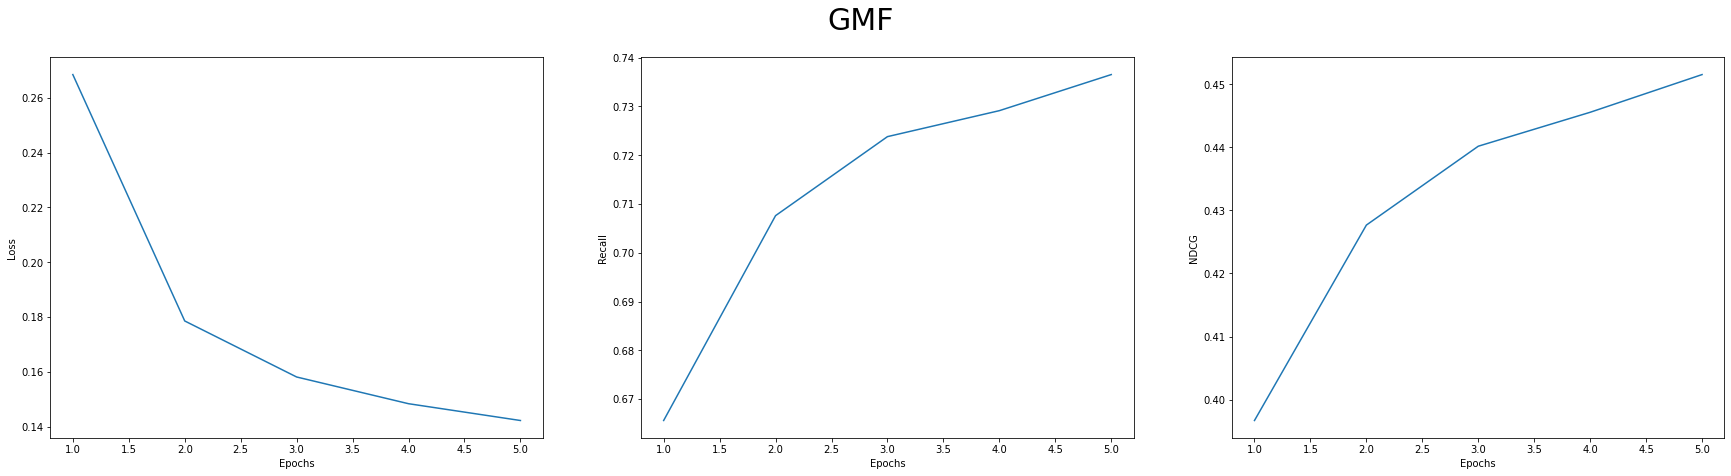

<Figure size 432x288 with 0 Axes>

In [31]:
all_loss = [GMF_trainer.loss_list, GMF_trainer.recall_list, GMF_trainer.ndcg_list]
plot_loss(hyper.epochs, all_loss, 'GMF', path.dir_output)

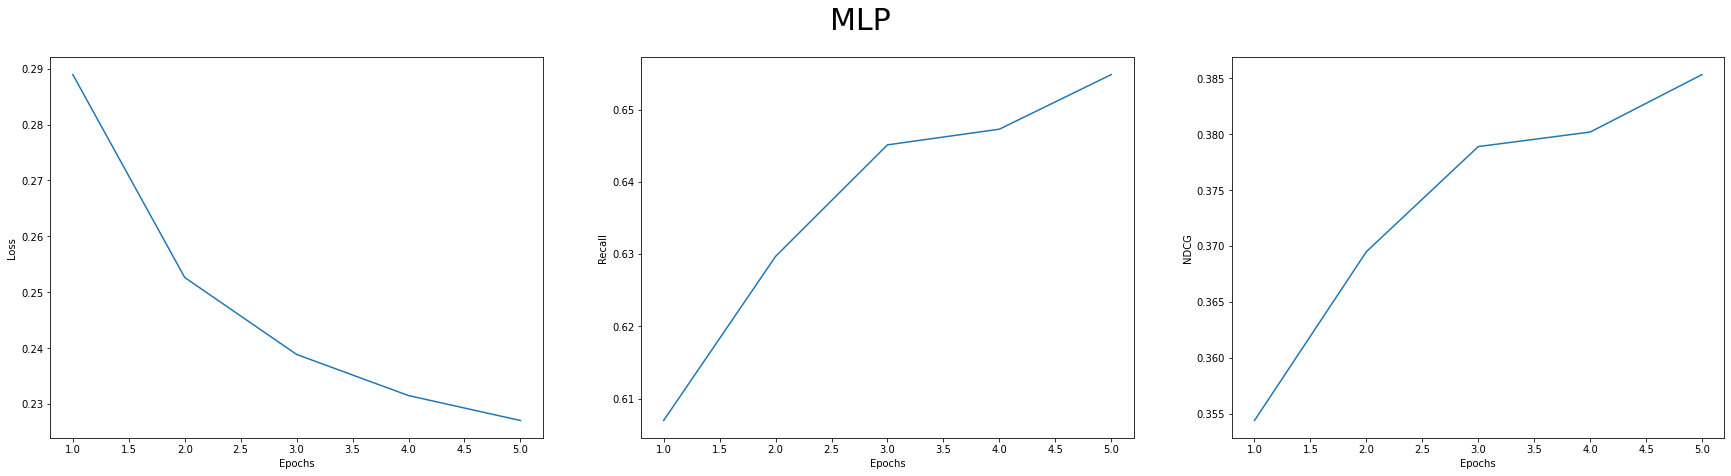

<Figure size 432x288 with 0 Axes>

In [32]:
all_loss = [MLP_trainer.loss_list, MLP_trainer.recall_list, MLP_trainer.ndcg_list]
plot_loss(hyper.epochs, all_loss, 'MLP', path.dir_output)

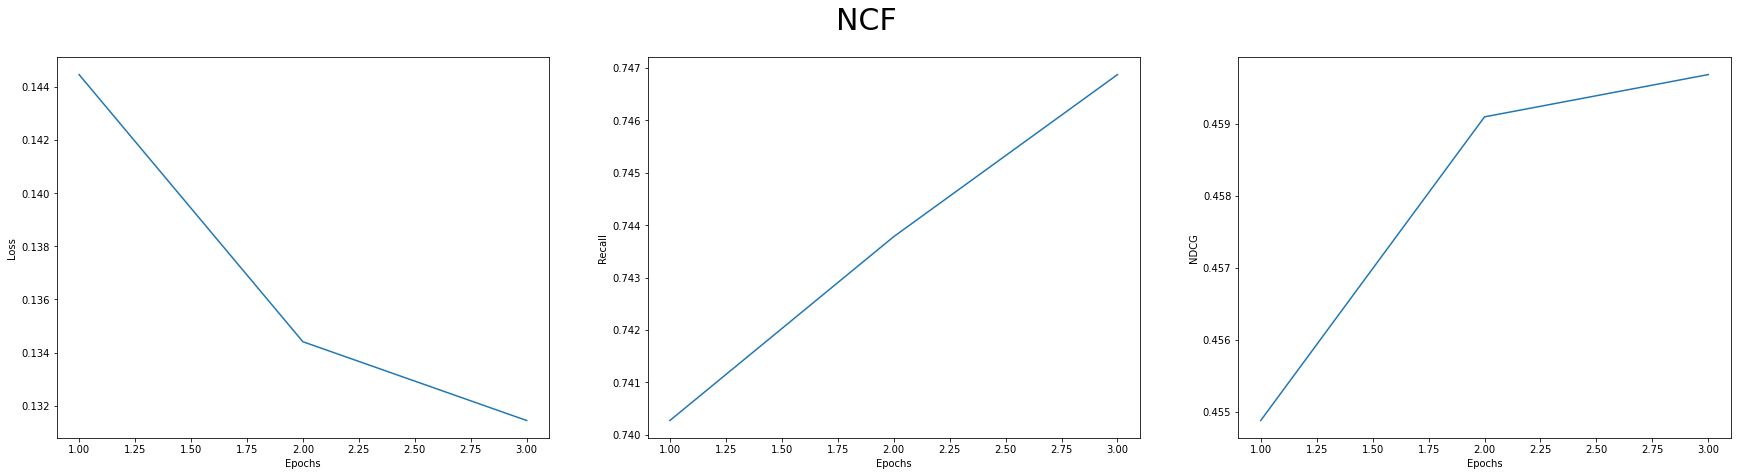

<Figure size 432x288 with 0 Axes>

In [33]:
all_loss = [NCF_trainer.loss_list, NCF_trainer.recall_list, NCF_trainer.ndcg_list]
plot_loss(hyper.pretrain_epochs, all_loss, 'NCF', path.dir_output)

In [ ]:
# model load

best_model = NCF(GMF_model, MLP_model, hyper.latent_dim, hyper.layers)
best_model.load_state_dict(torch.load(os.path.join(path.dir_output, 'best_NDCG_NCF_BPR.pt')))

best_model.to(config.device)

In [ ]:
def inference(model, users, negative_samples, topK, device, user_encoder, item_encoder, dir_output):
        model.eval()

        # columns: user_id
        df_item_user = pd.DataFrame(columns=user_encoder.inverse_transform([i for i in range(users)]))
        df_item_user.columns.name = 'user'
        df_item_user.index.name = 'order'
        
        with torch.no_grad():
            for user in tqdm(range(users)):
                neg_items = negative_samples[user]

                users, items = user_item_to_tensor(user, neg_items, device)

                output = model(users, items)
                _, indices = torch.topk(output, dim=0, k=topK)
                rank_list = torch.take(items, indices).cpu().numpy().tolist()

                origin_user = user_encoder.inverse_transform([user])[0]
                origin_items = item_encoder.inverse_transform(rank_list)
            
                df_item_user[origin_user] = origin_items
        
        df_prediction = pd.DataFrame(df_item_user.unstack()).reset_index()[['user', 0]]
        df_prediction.rename(columns={0: 'item'}, inplace=True)
        df_prediction.to_csv(os.path.join(dir_output, 'submission_BPR.csv'), index=False)
        return df_prediction


def user_item_to_tensor(user, negative_items, device):        
    users = [user] * len(negative_items)
    items = negative_items
    
    return (
        torch.tensor(users).to(torch.int64).to(device), 
        torch.tensor(items).to(torch.int64).to(device),
    )

In [ ]:
inference(best_model, data.num_users, data.user_negative_samples, hyper.topK, config.device, data.user_encoder, data.movie_encoder, path.dir_output)